In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress
import math # Import math for sqrt
import json # For saving results

In [4]:
torch.set_default_device('cuda')

# Loading CIFAR Data

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet18 (no final layer)
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Identity()
model = model.to(device)
model.eval()

# Data transform (resize to 224×224 and normalize)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ResNet defaults
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Extract embeddings
embeddings = []
with torch.no_grad():
    for i, (x, _) in enumerate(loader):
        if i * 64 >= 1000:
            break
        x = x.to(device)
        emb = model(x).cpu().numpy()  # move output to CPU before .numpy()
        embeddings.append(emb)

X = np.concatenate(embeddings, axis=0)  # shape: (1000, 512)

# Center and normalize rows
X_centered = X - X.mean(axis=0)
X_normed = X_centered / np.linalg.norm(X_centered, axis=1, keepdims=True)

# Condition number
print(f"Condition number: {np.linalg.cond(X_normed):.2f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]
100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Condition number: 80.85


# Load MNIST Data

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load the training and testing datasets
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Access the data and target tensors
train_data = train_dataset.data.float()
train_targets = train_dataset.targets
test_data = test_dataset.data.float()
test_targets = test_dataset.targets


# Calculate the mean of the training data
mean = train_data.mean()

# Centralize the training data by subtracting the mean
train_data_centered = train_data - mean

# Centralize the testing data by subtracting the same mean
test_data_centered = test_data - mean

# Verify that the centralized data has mean 0 (or very close to 0)
print(f"Mean of centered training data: {train_data_centered.mean()}")
print(f"Mean of centered testing data: {test_data_centered.mean()}")

Mean of centered training data: 1.0097789271412694e-07
Mean of centered testing data: 0.47280311584472656


# Helper Functions

In [5]:
def gradient_penalization_regularizer(W, X, a, gamma_m, lambda_reg, act="relu"):
    """
    Computes the gradient penalization regularizer.

    Args:
      W: Weight matrix (m, d).
      X: Data matrix (n, d).
      a: Activation vector (m,).
      gamma_m: Scaling factor.
      lambda_reg: Regularization strength.
      act: Activation function ("relu", "sigmoid", or "tanh").

    Returns:
      torch.Tensor: The gradient penalization regularizer.
    """
    # Calculate activation derivatives
    activation_deriv = activation_derivative(W @ X.T, act=act)  # (m, n)
    activation_deriv2 = activation_derivative_derivative(W @ X.T, act=act) # (m, n)

    # Calculate squared norms of x_i
    x_norms_squared = torch.norm(X, dim=1)**2  # (n,)

    # Calculate the regularizer
    regularizer = (lambda_reg * gamma_m**2 / X.shape[0]) * (
        (a**2).reshape(-1, 1) * x_norms_squared.reshape(1, -1)  # (m, n)
        * activation_deriv * activation_deriv2  # (m, n) element-wise multiplication
    )

    return (regularizer).T  # (n,m)

def activation_derivative_derivative(x, act="relu"):
    """
    Calculate the second derivative of the activation function
    """
    if act == "relu":
        return torch.zeros_like(x) #second derivative of relu is 0 everywhere
    elif act == "sigmoid":
        z = activation(x, act=act)
        return z * (1 - z) * (1 - 2 * z)
    elif act == "tanh":
        z = activation(x, act=act)
        return -2 * z * (1 - z**2)

In [6]:
def relative_projection_norm(W, v1, q):
  """
  Computes ||P_S(W)||_F / ||W||_F, where S = span(X^T*y, q).

  Args:
    W (torch.Tensor): Matrix to project (m, d).
    X (torch.Tensor): Data matrix (n, d).
    y (torch.Tensor): Target vector (n,) or (n, 1).
    q (torch.Tensor): Second spanning vector (d,) or (d, 1).

  Returns:
    float: Relative Frobenius norm of the projection. Returns 0.0 if ||W||_F is zero.
  """
  # if y.ndim == 1: y = y.unsqueeze(1)
  # if q.ndim == 1: q = q.unsqueeze(1)
  # v1 = X.T @ y # Shape (d, 1)

  # Create matrix of basis vectors (d, k), handle zero vectors implicitly via QR
  # Concatenate non-zero vectors robustly
  vec_list = [v for v in [v1, q] if torch.linalg.norm(v) > 1e-9]
  if not vec_list: return 0.0
  basis_mat = torch.cat(vec_list, dim=1)

  # Orthonormal basis Q (d, k) for the span (k=rank, <=2)
  Q, _ = torch.linalg.qr(basis_mat, mode='reduced')

  # Norm of projection || P_S(W) ||_F = || W @ Q ||_F
  norm_proj = torch.linalg.norm(W @ Q)
  norm_W = torch.linalg.norm(W)

  return (norm_proj / norm_W).item() if norm_W > 1e-9 else 0.0

In [7]:
def activation(x, act = "relu"):
  if act == "relu":
    # print("Activation ReLU")
    return torch.relu(x)
  elif act == "sigmoid":
    # print("Activation Sigmoid")
    return torch.sigmoid(x)
  elif act == "tanh":
    # print("Activation Tanh")
    return torch.tanh(x)
  elif act == "softplus":
    return torch.log(1 + torch.exp(x))
  elif act == "elu":
    return torch.where(x > 0, x, torch.exp(x) - 1)
  elif act == "swish":
    return x * torch.sigmoid(x)
  else:
    raise ValueError(f"Unknown activation function: {act}")

def activation_derivative(x, act = "relu"):
  if act == "relu":
    # print("Activation ReLU Derivative")
    return (x > 0).float()
  elif act == "sigmoid":
    # print("Activation Sigmoid Derivative")
    z = activation(x, act = act)
    return z * (1-z)
  elif act == "tanh":
    # print("Activation Tanh Derivative")
    z = activation(x, act = act)
    return 1 - z**2
  elif act == "softplus":
    return torch.sigmoid(x)
  elif act == "elu":
    return torch.where(x > 0, torch.ones_like(x), torch.exp(x))
  elif act == "swish":
    z = activation(x, act="sigmoid")  # Reuse sigmoid calculation
    return z + x * z * (1 - z)  # Applying the derivative formula

def gen_data(n, d, zeta, q, alpha = 0, return_all = False):
  """
    - q should be a d x 1 vector
  """
  Sigma = torch.diag(torch.arange(1,d+1) ** (-1*alpha/2))
  X_B = torch.randn(n,d) @ Sigma
  z = torch.randn(n,1)
  if not return_all:
    return X_B + zeta * z @ q.T
  else:
    return X_B + zeta * z @ q.T, z, X_B, zeta * z @ q.T

def get_y(X, f, tau = 1, loss_type = "MSE"):
  if loss_type == "MSE":
    y = torch.tensor([f(X[[i],:].T) for i in range(X.shape[0])])
    return y + torch.randn(y.shape) * tau
  elif loss_type == "bce":
    return torch.tensor([f(X[[i],:].T) for i in range(X.shape[0])])
  elif loss_type == "hinge":
    y = torch.tensor([f(X[[i],:].T) for i in range(X.shape[0])])
    return (y-0.5).sign()
  y = torch.tensor([f(X[[i],:].T) for i in range(X.shape[0])])
  return y + torch.randn(y.shape) * tau

def loss(X, W, a, y, gamma, act = "relu", loss_type = "MSE"):
  F = gamma * a.T @ activation(W @ X.T, act = act)
  if loss_type == "MSE":
    return torch.mean((F - y)**2)/2
  elif loss_type == "bce":
    z = activation(F, act = "sigmoid")
    return torch.mean(-y * torch.log(z) - (1-y) * torch.log(1-z))
  elif loss_type == "hinge":
    return torch.mean(torch.relu(1 - y * F))

def loss_derivative(X, W, a, y, gamma, act = "relu", loss_type = "MSE"):
  F = gamma * a.T @ activation(W @ X.T, act = act)
  if loss_type == "MSE":
    # print("Here")
    # print(F.shape, y.shape)
    return (F - y)
  elif loss_type == "bce":
    z = activation(F, act = "sigmoid")
    return z - y
  elif loss_type == "hinge":
    return torch.where(y * F < 1, -y, 0)

def get_mu(zeta, q, W, alpha, gamma, act = "sigmoid", loss_type = "MSE", n = 10000):
  d = q.shape[0]
  X = gen_data(n, d, zeta, q, alpha)
  Z = activation_derivative(W @ X.T, act = act)
  return Z.mean(dim = 1)

def activation_derivative_perp(X, W, mu, act = "relu"):
  return activation_derivative(X @ W.T, act = act) - mu.view(1,-1)

def activation_derivative_S2(X, W, mu, act = "relu"):
  return activation_derivative(X @ W.T, act = act)

def get_S1_exp(zeta, q, f, a, mu, alpha, gamma,  act = "relu", loss_type = "MSE", n = 10000):
  d = q.shape[0]
  X = gen_data(n, d, zeta, q, alpha)
  y = get_y(X, f)
  r = loss_derivative(X, W, a, y, gamma, act = act, loss_type = loss_type).view(-1,1)
  return (X.T @ r @ (a * mu).T) / n

def get_S1(X, r, a, mu):
  # print(mu.shape, a.shape)
  return X.T @ r @ (a * mu).T / X.shape[0]

def get_S1_perp(X, W, mu, a, r, act = "relu", loss_type = "MSE"):
  sigma_prime_perp = activation_derivative_perp(X, W, mu, act = act)
  return X.T @ ((r @ a.T) * sigma_prime_perp) / X.shape[0]

def get_G(X, W, y, r, a, act = "relu", loss_type = "MSE"):
  sigma_prime = activation_derivative(X @ W.T, act = act)

  G = X.T @ ((r @ a.T) * sigma_prime)
  return G / X.shape[0]

def get_S2(X, X_S, mu, r, W, a, y, alpha, act = "relu", loss_type = "MSE"):
  d = q.shape[0]
  sigma_prime_perp = activation_derivative_S2(X, W, mu, act = act)

  return X_S.T @ ((r @ a.T) * sigma_prime_perp) / X_S.shape[0]

def get_S2_small(X, X_S, mu, r, W, a, y, alpha, act = "relu", loss_type = "MSE"):
  d = q.shape[0]
  sigma_prime_perp = activation_derivative_perp(X, W, mu, act = act)

  return X_S.T @ ((r @ a.T) * sigma_prime_perp) / X_S.shape[0]

def get_E(X, X_B, W, mu, a, r, y, act = "relu", loss_type = "MSE"):
  sigma_prime_perp = activation_derivative_perp(X, W, mu, act = act)

  return X_B.T @ ((r @ a.T) * sigma_prime_perp) / X_B.shape[0]

def operator_norm(A):
  return largest_singular_value(A)

def largest_singular_value(A, num_iterations=200):
    """
    Approximates the largest singular value of a matrix using power iteration.

    Args:
        A: The input matrix (torch.Tensor).
        num_iterations: The number of iterations to perform.

    Returns:
        The estimated largest singular value.
    """

    v = torch.randn(A.shape[1], device=A.device)  # Random initialization
    v = v / torch.norm(v)

    for _ in range(num_iterations):
        u = A @ v
        v = A.T @ u
        v = v / torch.norm(v)

    return torch.norm(u)  # Largest singular value approximation


# Setup and Run Triple Index Experiments

In [ ]:
n = 750
d = 1000
m = 1250

beta1 = torch.randn(d,1)
beta1 = beta1/torch.norm(beta1)

beta2 = torch.randn(d,1)
beta2 = beta2/torch.norm(beta2)

beta3 = torch.randn(d,1)
beta3 = beta3/torch.norm(beta3)

def f(x):
  return activation(x.T @ beta1, act = "sigmoid") + activation(x.T @ beta2, act = "tanh") + activation(x.T @ beta3, act = "relu")

In [ ]:
nu = 6/8
alpha = 0
gamma = 1/np.sqrt(m)
act = "relu"
loss_type = "MSE"

In [ ]:
q = torch.randn(d,1)
q = q/torch.norm(q)

In [ ]:
X, z, X_B, X_S = gen_data(n, d, n**nu, q, alpha, return_all=True)
y = get_y(X, f)

In [ ]:
a = torch.randint(0, 2, (m,1)).float() - 1
W = torch.randn(m,d)

# W = W @ X.T @ X

# # Calculate the projection of W onto q.
# projection = (W @ q / torch.norm(q)**2) * q.T  # (m,d)
# # print(projection.shape)
# # Subtract the projection from W.
# W = W - projection

# W += n * torch.ones(m,1)/np.sqrt(m) @ q.T + W

for i in range(m):
  W[i,:] /= torch.norm(W[i,:])

operator_norm(W)

tensor(2.1141, device='cuda:0')

In [ ]:
G = gamma * get_G(X, W, y, r, a, act = act, loss_type = loss_type)
print(G.shape)

torch.Size([1000, 1250])


In [ ]:
noise_level = 0

In [ ]:
# Uncomment to add input data noise

# noise = torch.randn_like(X_B)*noise_level
# X_B += noise
# X += noise

In [ ]:
mu = get_mu(n**nu, q, W, alpha, gamma, act = act).view(-1,1)
r = loss_derivative(X, W, a, y, gamma, act = act, loss_type = loss_type).view(-1,1)

In [ ]:
# Uncomment for gradient penalty regularization

# E2 = X_B.T @ gradient_penalization_regularizer(W, X, a, gamma, noise_level, act = act)
# S3 = X_S.T @ gradient_penalization_regularizer(W, X, a, gamma, noise_level, act = act)
# Reg = X.T @ gradient_penalization_regularizer(W, X, a, gamma, noise_level, act = act)
# G = G + Reg

In [ ]:
S1 = gamma * get_S1(X_B, r, a, mu)
print(S1.shape)

torch.Size([1000, 1250])


In [ ]:
S2 = gamma * get_S2_small(X, X_S, mu, r, W, a, y, alpha, act = act, loss_type = loss_type)
print(S2.shape)

torch.Size([1000, 1250])


In [ ]:
E = gamma * get_E(X, X_B, W, mu, a, r, y, act = act, loss_type = loss_type)
print(E.shape)

torch.Size([1000, 1250])


In [ ]:
S12 = gamma * get_S1(X_S, r, a, mu)

In [ ]:
R = S1+S12+S2
(G - R - E).norm()/G.norm()

tensor(5.0821e-07, device='cuda:0')

In [ ]:
print(operator_norm(G).cpu().item(),
      operator_norm(S1).cpu().item(),
      operator_norm(S12).cpu().item(),
      operator_norm(S2).cpu().item(),
      operator_norm(E).cpu().item())
      # operator_norm(S3).cpu().item(),
      # operator_norm(E2).cpu().item())

1487.3070068359375 13.013351440429688 28.41252899169922 1485.3743896484375 11.295745849609375


In [ ]:
R = S1+S12+S2 # + S3 For gradient penalty regularization. Add this.
U,S,Vh = torch.linalg.svd(R)
u1 = U[:,0]
u2 = U[:,1]

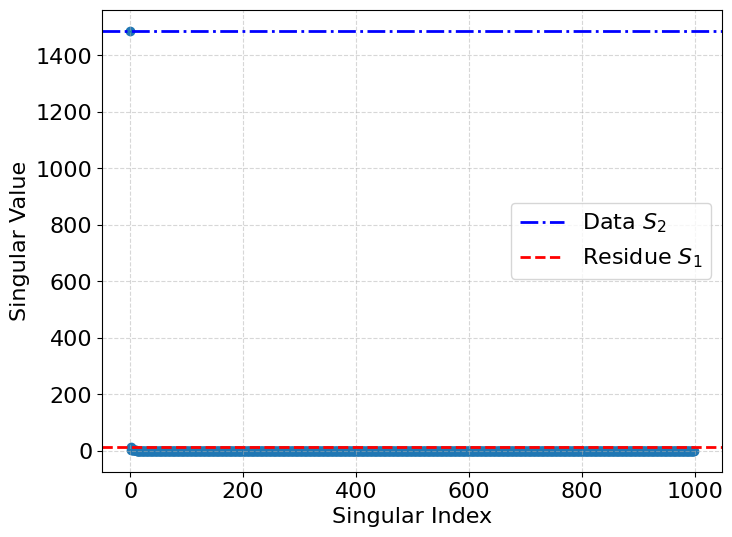

In [ ]:
# Create the histogram
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
G_singular_values = np.linalg.svd(G.cpu().numpy(), compute_uv=False)
plt.scatter(torch.arange(G_singular_values.shape[0]).cpu(),G_singular_values)

# Highlight the two largest singular values
largest_singular_values = [S[0],S[1]]  # Get the two largest
# largest_singular_values = [operator_norm(S1), operator_norm(S2), operator_norm(S12+S2)]  # Get the two largest
# colors = ['red', 'blue'
# colors = ['red', 'blue']
colors = ['red', 'blue', 'green']  # Different colors for each line
linestyles = ['--', '-.', ':']  # Different linestyles for each line
for i, value in enumerate(largest_singular_values):
    if (U[:,i].T @ q).abs() > (U[:,i].T @ (X_B.T @ r)/(torch.norm(X_B.T @ r))).abs():
    # if i == 1:
      plt.axhline(y=value.cpu(), color="blue", linestyle="-.", linewidth=2,
                label=r"Data $S_2$")
    else:
      plt.axhline(y=value.cpu(), color="red", linestyle="--", linewidth=2,
                  label=r"Residue $S_1$")

# Customize plot elements for publication quality
plt.xlabel("Singular Index", fontsize=16)  # Update x-axis label
plt.ylabel("Singular Value", fontsize=16)
# plt.title("Histogram of Singular Values of G", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize = 16) # Show the legend
# plt.yscale('log')  # Set x-axis to logarithmic scale
# plt.ylim(bottom = 1e-3)

# Save the figure (optional)
# plt.savefig("Embedded-Cifar-gradient-penalty-"+str(noise_level)+"-triple-index.pdf", dpi=300, bbox_inches='tight')
# plt.savefig("gamma-"+str(gamma)+"nu-"+str(nu)+"-alpha-"+str(alpha)+"-"+act+"-"+loss_type+"-n-"+str(n)+"-d-"+str(d)+"-m-"+str(m)+"-triple-index.pdf", dpi=300, bbox_inches='tight')
# plt.savefig("Isotropic-W-gamma-"+str(gamma)+"nu-"+str(nu)+"-alpha-"+str(alpha)+"-"+act+"-"+loss_type+"-n-"+str(n)+"-d-"+str(d)+"-m-"+str(m)+"-triple-index.pdf", dpi=300, bbox_inches='tight')
# plt.savefig("gamma-"+str(gamma)+"nu-"+str(nu)+"-alpha-"+str(alpha)+"-"+act+"-"+loss_type+"-n-"+str(n)+"-d-"+str(d)+"-m-"+str(m)+"-input-noise-"+str(noise_level)+"-triple-index.pdf", dpi=300, bbox_inches='tight')

plt.show()

# Check Alignment of Singular Vectors

In [ ]:
(U[:,:2] @ U[:,:2].T @ G).norm()/G.norm()

tensor(1.0005, device='cuda:0')

In [ ]:
relative_projection_norm(G.T, u1.view(-1,1), u2.view(-1,1))

0.12630337476730347

In [ ]:
u = torch.linalg.svd(G.cpu())[0][:,0]
u.T @ (X_B.T @ r).cpu()/(torch.norm(X_B.T @ r).cpu())

tensor([-0.2931])

In [ ]:
u.T @ (X.T @ r).cpu()/(torch.norm(X.T @ r).cpu())

tensor([-0.9476])

In [ ]:
u.T @ q.cpu()

tensor([0.9540])

In [ ]:
u.T @ u1.cpu()

tensor(-0.9974)

In [ ]:
u.T @ u2.cpu()

tensor(-0.0144)

# Later in Training Experiments

In [ ]:
def effective_rank(matrix):
  """
  Calculates the effective rank of a matrix.

  Args:
    matrix: A PyTorch tensor representing the matrix.

  Returns:
    The effective rank of the matrix.
  """
  s = torch.linalg.svdvals(matrix)
  normalized_s = s / torch.sum(s)
  entropy = -torch.sum(normalized_s * torch.log(normalized_s + 1e-8))
  return torch.exp(entropy)


In [ ]:
from tqdm.auto import tqdm

n = 750
d = 1000
m = 1250

beta1 = torch.randn(d,1)
beta1 = beta1/torch.norm(beta1)

beta2 = torch.randn(d,1)
beta2 = beta2/torch.norm(beta2)

beta3 = torch.randn(d,1)
beta3 = beta3/torch.norm(beta3)

def f(x):
  return activation(x.T @ beta1, act = "sigmoid") + activation(x.T @ beta2, act = "tanh") + activation(x.T @ beta3, act = "relu")

nu = 2/16
alpha = 0
gamma = 1/m
act = "tanh"
loss_type = "MSE"

M = 100

avg_error = torch.zeros(M)

S1_norm = torch.zeros(M)
S2_norm = torch.zeros(M)
S12_norm = torch.zeros(M)
E_norm = torch.zeros(M)

energy_G = torch.zeros(M)
energy_W = torch.zeros(M)

betas = torch.zeros(M)

mu_min = torch.zeros(M)
mu_max = torch.zeros(M)
mu_norm = torch.zeros(M)

r_max = torch.zeros(M)
r_norm = torch.zeros(M)

W_norm = torch.zeros(M)

effective_rank_W = torch.zeros(M)
effective_rank_G = torch.zeros(M)

SPP_norm = torch.zeros(M)
idx = -1

q = torch.randn(d,1)
q = q/torch.norm(q)

a = torch.randint(0, 2, (m,1)).float() - 1
a = a/torch.norm(a)
W = torch.randn(m,d)

u1_alignment = torch.zeros(M)
u2_alignment = torch.zeros(M)
u3_alignment = torch.zeros(M)

S1_E = torch.zeros(M)
S2_E = torch.zeros(M)
S12_E = torch.zeros(M)

X, z, X_B, X_S = gen_data(n, d, n**nu, q, alpha, return_all=True)
y = get_y(X, f, loss_type = loss_type)

eta = m

for t in tqdm(range(M)):

  for i in range(m):
    W[i,:] /= torch.norm(W[i,:])


  mu = get_mu(n**nu, q, W, alpha, gamma, act = act).view(-1,1)
  r = loss_derivative(X, W, a, y, gamma, act = act, loss_type = loss_type).view(-1,1)

  G = gamma * get_G(X, W, y, r, a, act = act, loss_type = loss_type)
  S1 = gamma * get_S1(X_B, r, a, mu)
  S2 = gamma * get_S2_small(X, X_S, mu, r, W, a, y, alpha, act = act, loss_type = loss_type)
  S12 = gamma * get_S1(X_S, r, a, mu)
  E = gamma * get_E(X, X_B, W, mu, a, r, y, act = act, loss_type = loss_type)

  R = S1+S12+S2
  U,S,Vh = torch.linalg.svd(R)
  # u1 = U[:,0]
  # u2 = U[:,1]

  u1 = (X_B.T @ r)/(torch.norm(X_B.T @ r))
  u2 = q
  u3 = (X_B.T @ y)/ (torch.norm(X_B.T @ y))

  energy_G[t] = (U[:,:2] @ U[:,:2].T @ G).norm()/G.norm()
  energy_W[t] = (U[:,:2] @ U[:,:2].T @ W.T).norm()/W.norm()

  u = torch.linalg.svd(G.cpu())[0][:,0]

  u1_alignment[t] = (u.T @ u1.cpu()).abs()
  u2_alignment[t] = (u.T @ u2.cpu()).abs()
  u3_alignment[t] = (u.T @ u3.cpu()).abs()

  S1_E[t] = (operator_norm(S1)/operator_norm(E)).cpu()
  S12_E[t] = (operator_norm(S12)/operator_norm(E)).cpu()
  S2_E[t] = (operator_norm(S2)/operator_norm(E)).cpu()

  betas[t] += (z.T @ r / (torch.norm(r)*torch.norm(z))).abs().item()

  mu_min[t] = mu.abs().min()
  mu_max[t] = mu.abs().max()
  mu_norm[t] = mu.norm()

  r_max[t] = r.abs().max()
  r_norm[t] = r.norm()

  S1_norm[t] = operator_norm(S1)
  S2_norm[t] = operator_norm(S2)
  S12_norm[t] = operator_norm(S12)
  E_norm[t] = operator_norm(E)

  W_norm[t] = operator_norm(W)

  effective_rank_W[t] = effective_rank(W)
  effective_rank_G[t] = effective_rank(G)

  spp = activation_derivative_perp(X, W, mu, act = act)
  SPP_norm[t] = operator_norm(spp)
  avg_error[t] = (operator_norm(G - S1 - S12 - S2))

  W = W - eta*G.T

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import matplotlib.ticker as ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

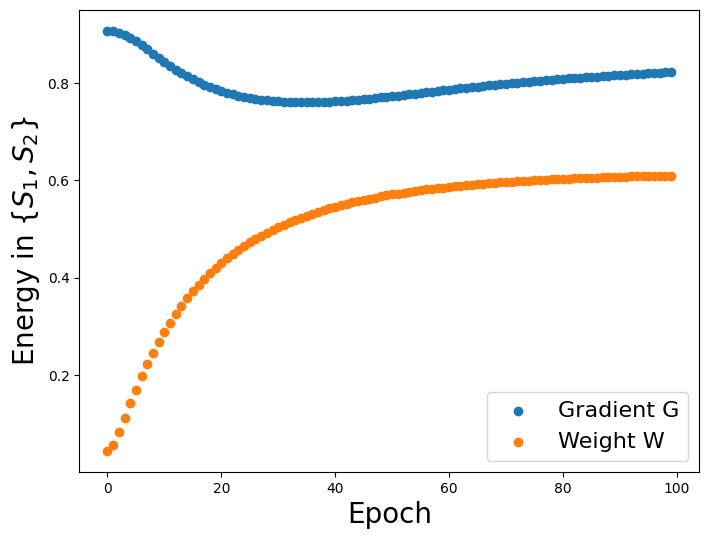

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(torch.arange(M).cpu(),energy_G.cpu(), label = "Gradient G")
plt.scatter(torch.arange(M).cpu(),energy_W.cpu(), label = "Weight W")
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel(r"Energy in $\{S_1,S_2\}$", fontsize =20)
# plt.title(r"$\gamma = \frac{1}{\sqrt{m}}$ and $\eta = \sqrt{m^3}$, $\nu = \frac{1}{8}$, $\alpha = 0$", fontsize = 20)
plt.legend(fontsize = 16)
plt.savefig("energy-MF-"+act+"-"+loss_type+"-nu-"+str(nu)+"-gamma-"+str(gamma)+"-eta-"+str(eta)+"-.pdf", dpi=100, bbox_inches='tight')

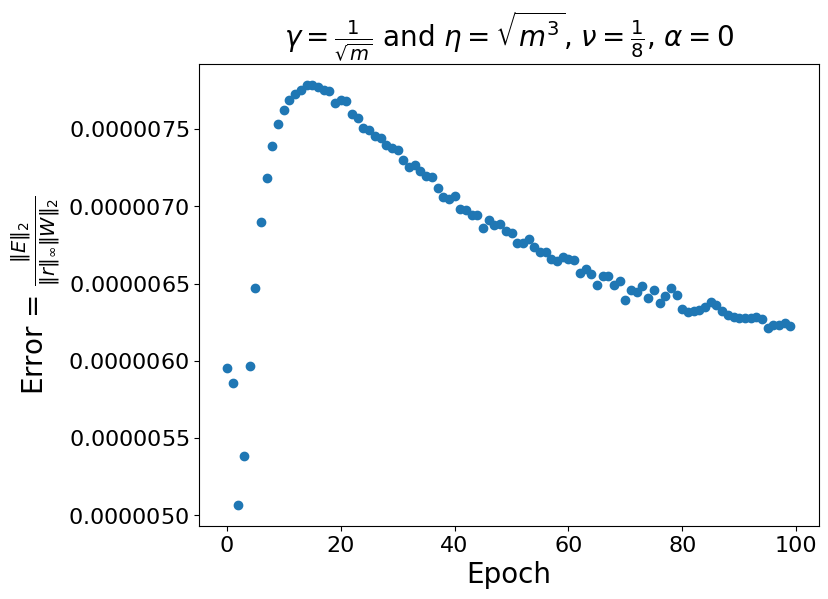

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(torch.arange(M).cpu(),avg_error.cpu()/(r_max*W_norm).cpu())
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel(r"Error = $\frac{\|E\|_2}{\|r\|_{\infty}\|W\|_2}$", fontsize =20)
plt.title(r"$\gamma = \frac{1}{\sqrt{m}}$ and $\eta = \sqrt{m^3}$, $\nu = \frac{1}{8}$, $\alpha = 0$", fontsize = 20)
# plt.legend(fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))  # Optional: Adjust power limits if needed
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(formatter)
plt.savefig("error-MF-"+act+"-"+loss_type+"-nu-"+str(nu)+"-gamma-"+str(gamma)+"-eta-"+str(eta)+"-.pdf", dpi=100, bbox_inches='tight')

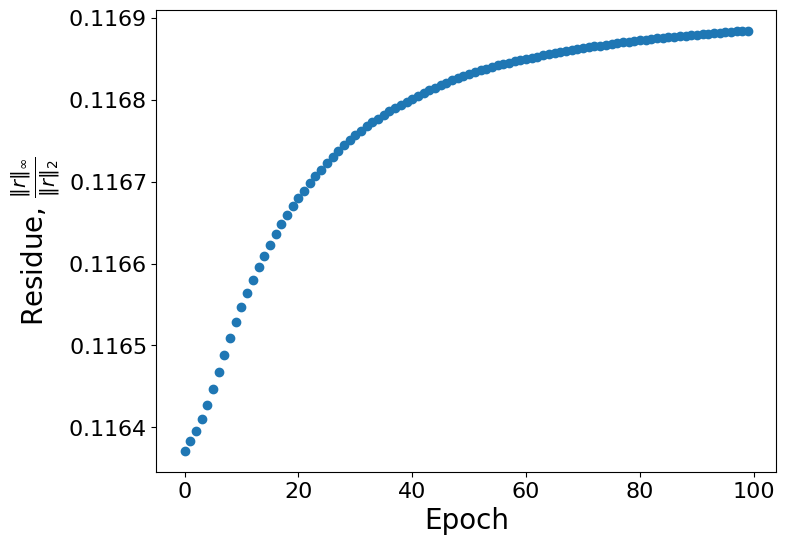

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(torch.arange(M).cpu(),r_max.cpu()/r_norm.cpu())
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel(r"Residue, $\frac{\|r\|_\infty}{\|r\|_2}$", fontsize =20)
# plt.title(r"$\gamma = \frac{1}{\sqrt{m}}$ and $\eta = \sqrt{m^3}$, $\nu = \frac{1}{8}$, $\alpha = 0$", fontsize = 20)
# plt.legend(fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))  # Optional: Adjust power limits if needed
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(formatter)
plt.savefig("residue-MF-"+act+"-"+loss_type+"-nu-"+str(nu)+"-gamma-"+str(gamma)+"-eta-"+str(eta)+"-.pdf", dpi=100, bbox_inches='tight')

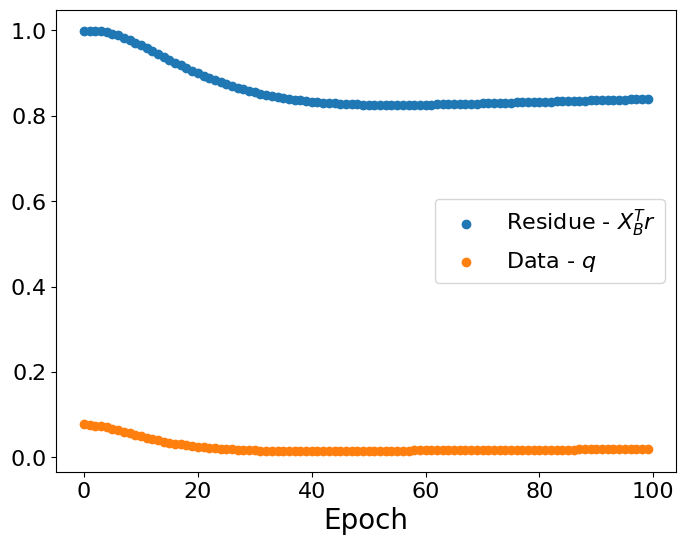

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(torch.arange(M).cpu(),u1_alignment.cpu(), label = r"Residue - $X_B^Tr$")
plt.scatter(torch.arange(M).cpu(),u2_alignment.cpu(), label = r"Data - $q$")
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel(r"", fontsize =20)
# plt.title(r"$\gamma = \frac{1}{\sqrt{m}}$ and $\eta = \sqrt{m^3}$, $\nu = \frac{1}{8}$, $\alpha = 0$", fontsize = 20)
plt.legend(fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))  # Optional: Adjust power limits if needed
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(formatter)
plt.savefig("alignment-MF-"+act+"-"+loss_type+"-nu-"+str(nu)+"-gamma-"+str(gamma)+"-eta-"+str(eta)+"-.pdf", dpi=100, bbox_inches='tight')

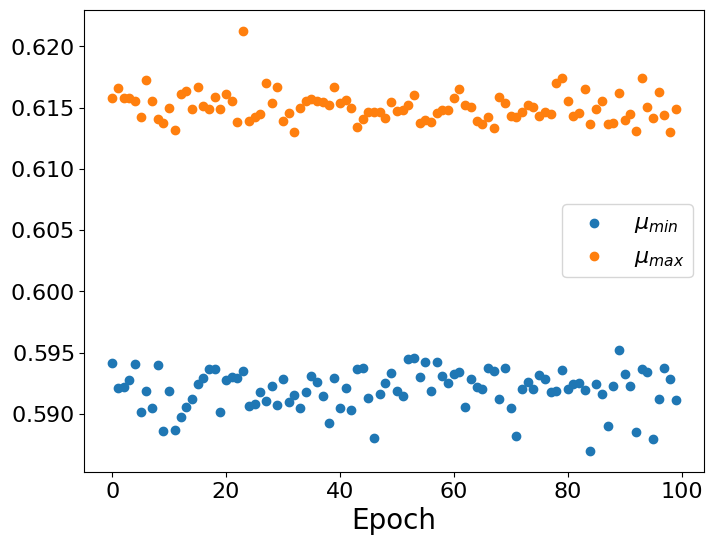

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(torch.arange(M).cpu(),mu_min.cpu(), label = r"$\mu_{min}$")
plt.scatter(torch.arange(M).cpu(),mu_max.cpu(), label = r"$\mu_{max}$")
plt.xlabel("Epoch", fontsize = 20)
# plt.ylabel(r"Residue, $\frac{\|r\|_\infty}{\|r\|_2}$", fontsize =20)
# plt.title(r"$\gamma = \frac{1}{\sqrt{m}}$ and $\eta = \sqrt{m^3}$, $\nu = \frac{1}{8}$, $\alpha = 0$", fontsize = 20)
plt.legend(fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))  # Optional: Adjust power limits if needed
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(formatter)
plt.savefig("mu-MF-"+act+"-"+loss_type+"-nu-"+str(nu)+"-gamma-"+str(gamma)+"-eta-"+str(eta)+"-.pdf", dpi=100, bbox_inches='tight')

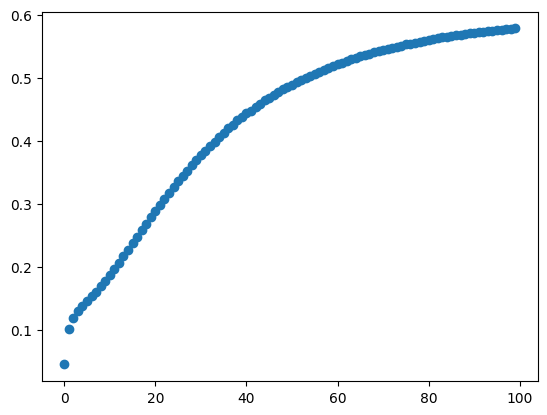

In [ ]:
plt.scatter(torch.arange(M).cpu(),energy_W.cpu())

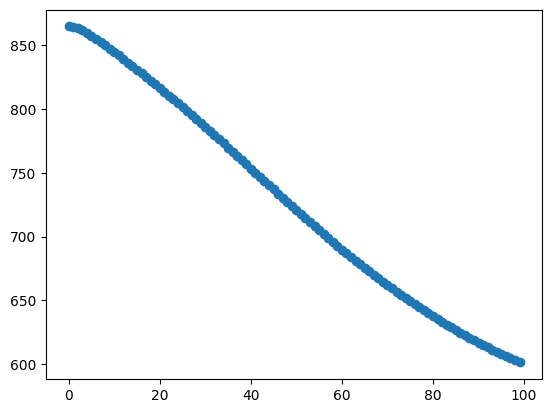

In [ ]:
plt.scatter(torch.arange(M).cpu(),effective_rank_W.cpu())

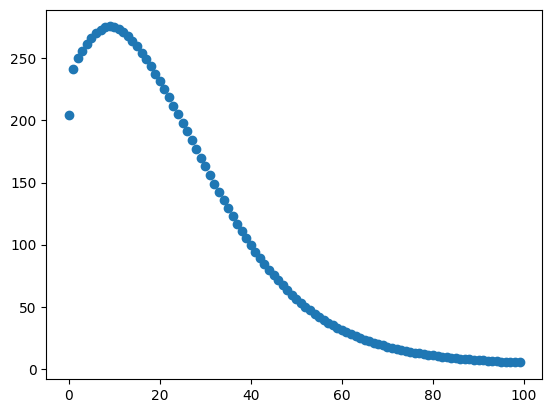

In [ ]:
plt.scatter(torch.arange(M).cpu(),effective_rank_G.cpu())

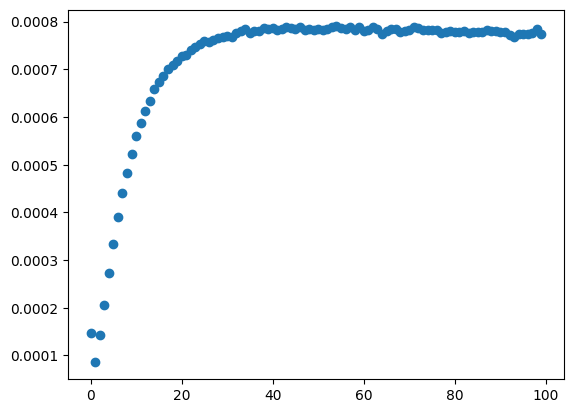

In [ ]:
plt.scatter(torch.arange(M).cpu(),E_norm.cpu())

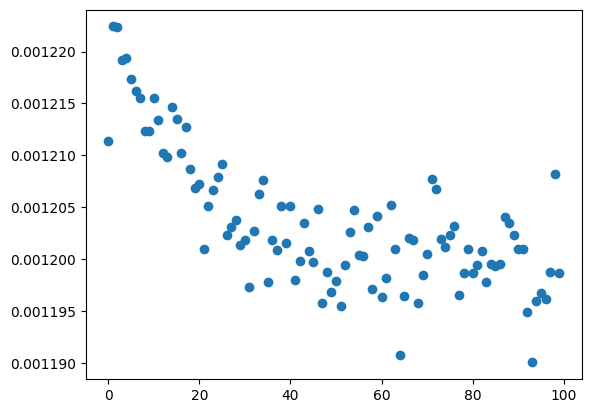

In [ ]:
plt.scatter(torch.arange(M).cpu(),S1_norm.cpu())

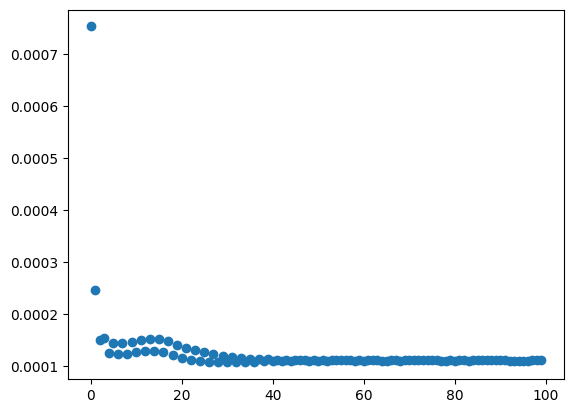

In [ ]:
plt.scatter(torch.arange(M).cpu(),S2_norm.cpu())

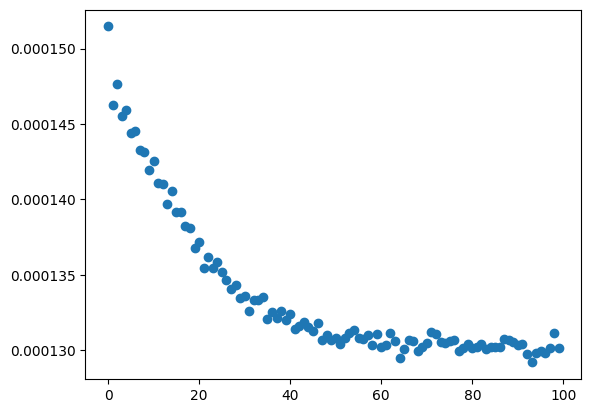

In [ ]:
plt.scatter(torch.arange(M).cpu(),S12_norm.cpu())

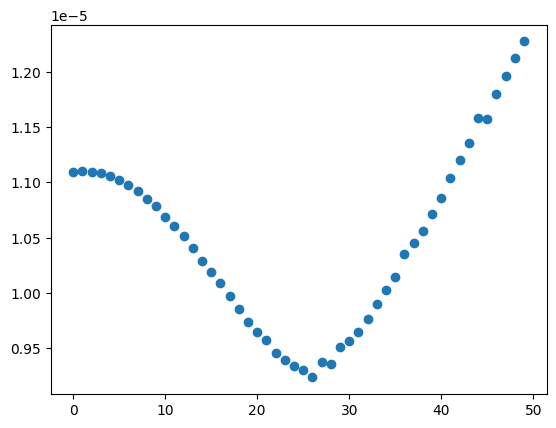

In [ ]:
plt.scatter(torch.arange(M).cpu(),avg_error.cpu())

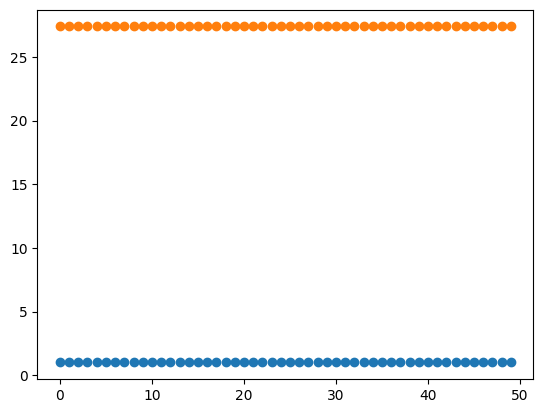

In [ ]:
plt.scatter(torch.arange(M).cpu(),r_max.cpu())
plt.scatter(torch.arange(M).cpu(),r_norm.cpu())

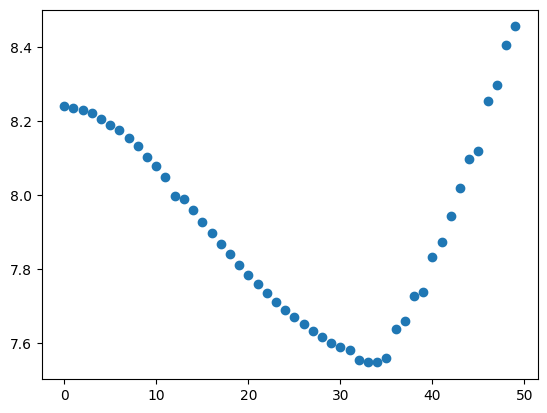

In [ ]:
plt.scatter(torch.arange(M).cpu(),SPP_norm.cpu())

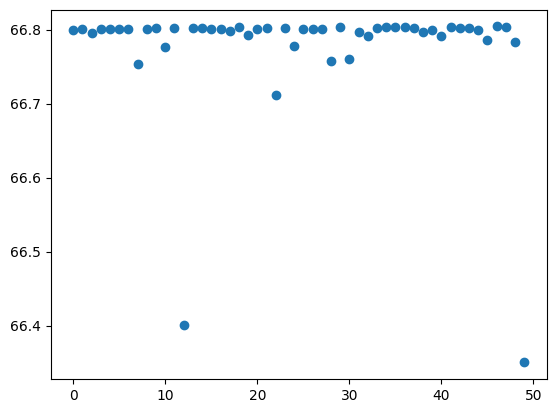

In [ ]:
plt.scatter(torch.arange(M).cpu(),W_norm.cpu())

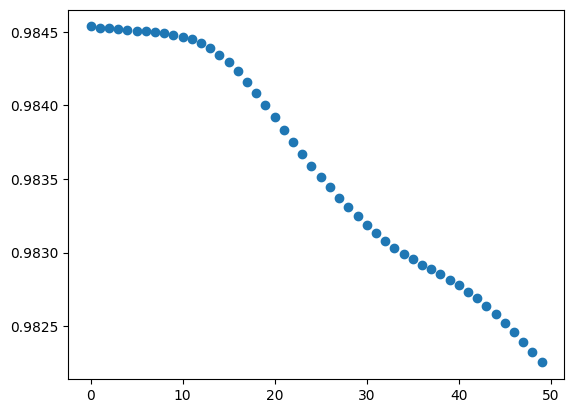

In [ ]:
plt.scatter(torch.arange(M).cpu(),u3_alignment.cpu())

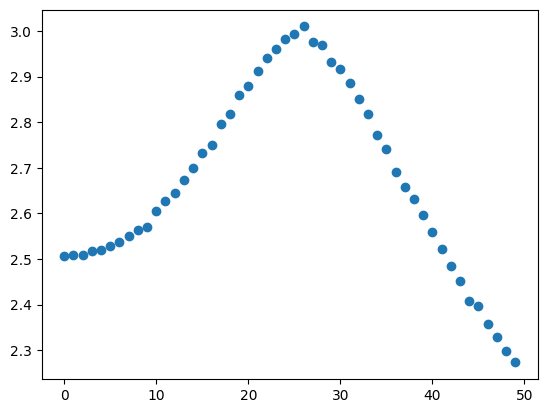

In [ ]:
plt.scatter(torch.arange(M).cpu(),S1_E.cpu())

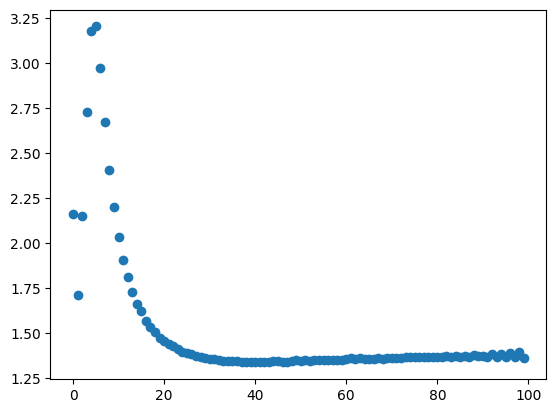

In [ ]:
plt.scatter(torch.arange(M).cpu(),S2_E.cpu())

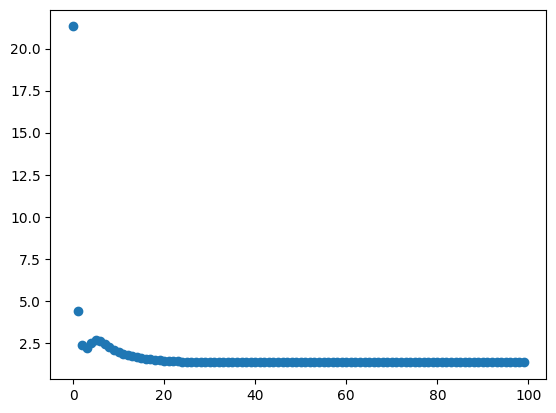

In [ ]:
plt.scatter(torch.arange(M).cpu(),S12_E.cpu())

# Estimating Beta Experiment

In [21]:
def estimate_beta(n_values, avg_cos_sims): # Added show_plots flag
    """ Performs log-log regression to estimate beta. Plots |cos| vs n """

    # print(valid_indices)
    # print(n_values_valid)
    # print(avg_cos_sims_valid)

    beta_est = np.nan # Default
    plot_data = None # Default

    log_n = n_values.log().numpy()
    log_cos = avg_cos_sims.log().numpy()

    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_cos)
    beta_est = -2.0 * slope

    return beta_est

In [ ]:
n_s = 750
d_s = 1000
m_s = 1250

def f(x):
  return activation(x.T @ beta, act = "sigmoid")

betas = []


for act in ["sigmoid", "relu", "tanh"]:
  for loss_type in ["MSE", "bce", "hinge"]:
    print(act, loss_type)
    for nu in [1/8, 3/8, 5/8]:
      for alpha in [0, 1/2]:
        print(nu, alpha)
        M = 5
        avg_prod = torch.zeros(M)
        for i in range(1,M+1):
          n = n_s * i
          d = d_s * i
          m = m_s * i

          beta = torch.randn(d,1)
          beta = beta/torch.norm(beta)

          q = torch.randn(d,1)
          q = q/torch.norm(q)

          a = torch.randint(0, 2, (m,1)).float() - 1

          W = torch.randn(m,d)
          for j in range(m):
            W[j,:] /= torch.norm(W[j,:])

          gamma = 1/m_s

          for t in range(10):

            X, z, X_B, X_S = gen_data(n, d, n**nu, q, alpha, return_all=True)
            y = get_y(X, f, loss_type = loss_type)

            mu = get_mu(n**nu, q, W, alpha, gamma, act = act, loss_type = loss_type).view(-1,1)
            r = loss_derivative(X, W, a, y, gamma, act = act, loss_type = loss_type).view(-1,1)

            avg_prod[i-1] += (z.T @ r / (torch.norm(r)*torch.norm(z))).abs().item()/10
        # print(avg_prod)
        betas.append(estimate_beta(torch.arange(1,M+1).cpu()*n_s,avg_prod.cpu()))

sigmoid MSE
0.125 0
0.125 0.5
0.375 0
0.375 0.5
0.625 0
0.625 0.5
sigmoid bce
0.125 0
0.125 0.5
0.375 0
0.375 0.5
0.625 0
0.625 0.5
sigmoid hinge
0.125 0
0.125 0.5
0.375 0
0.375 0.5
0.625 0
0.625 0.5
relu MSE
0.125 0


In [ ]:
plt.hist(betas)

In [ ]:
n_s = 750
d_s = 1000
m_s = 1250

def f(x):
  return activation(x.T @ beta, act = "sigmoid")

betas_ntk = []


for act in ["sigmoid", "relu", "tanh"]:
  for loss_type in ["MSE", "bce", "hinge"]:
    print(act, loss_type)
    for nu in [1/8, 3/8, 5/8]:
      for alpha in [0, 1/2]:
        print(nu, alpha)
        M = 5
        avg_prod = torch.zeros(M)
        for i in range(1,M+1):
          n = n_s * i
          d = d_s * i
          m = m_s * i

          beta = torch.randn(d,1)
          beta = beta/torch.norm(beta)

          q = torch.randn(d,1)
          q = q/torch.norm(q)

          a = torch.randint(0, 2, (m,1)).float() - 1

          W = torch.randn(m,d)
          for j in range(m):
            W[j,:] /= torch.norm(W[j,:])

          gamma = 1/np.sqrt(m_s)

          for t in range(10):

            X, z, X_B, X_S = gen_data(n, d, n**nu, q, alpha, return_all=True)
            y = get_y(X, f, loss_type = loss_type)

            mu = get_mu(n**nu, q, W, alpha, gamma, act = act, loss_type = loss_type).view(-1,1)
            r = loss_derivative(X, W, a, y, gamma, act = act, loss_type = loss_type).view(-1,1)

            avg_prod[i-1] += (z.T @ r / (torch.norm(r)*torch.norm(z))).abs().item()/10
        # print(avg_prod)
        betas_ntk.append(estimate_beta(torch.arange(1,M+1).cpu()*n_s,avg_prod.cpu()))

In [ ]:
plt.hist(betas_ntk)